# 2022年7月30日21:57:46

想象有这样一个二维空间场景：把一个高温的，比如为600℃，圆形铁饼放在一个正方形的空间内，该空间内的环境温度是固定的，比如为室温25℃，或者0℃。研究经过一个固定的时间，比如1小时，后铁饼的温度。

# 1. 物理模型

传热方程如下：
$$\frac{\partial T}{\partial t}=\alpha (\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2})$$

其中$\alpha=\frac{k}{\rho c}$为热扩散系数，$k,\rho,c$分别为材料的热导率($\frac{W}{m\cdot K}$)，密度($\frac{kg}{m^3}$)，比热容($\frac{J}{kg \cdot K}$)

不考虑对流和热辐射，且假定材料为铁，半径为0.2，温度为600℃；环境空间边长为1，温度为25℃

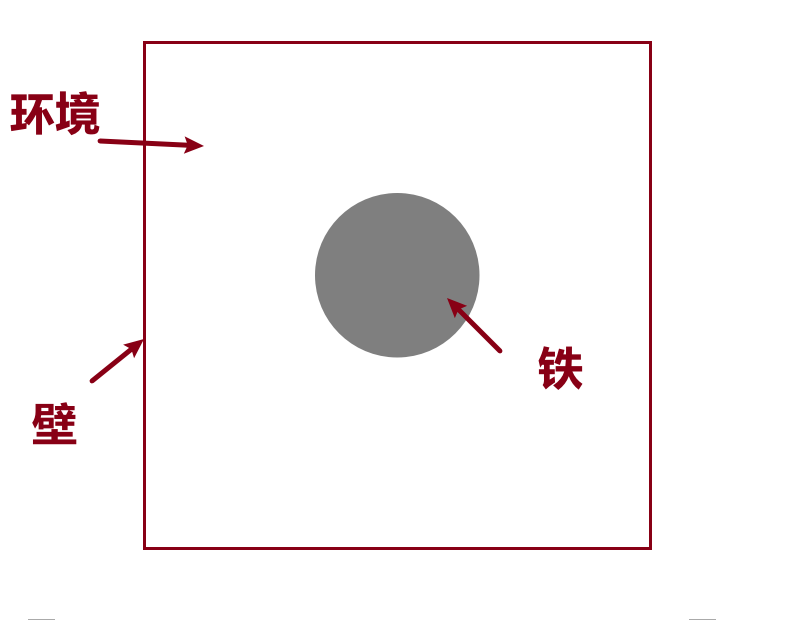

# 2. 离散化

对于时间的离散

$$\frac{\partial T}{\partial t}=\frac{T^{m+1}-T^{m}}{\Delta t}$$

其中$T^m$表示当前时刻的温度，$T^{m+1}$表示下一个时刻的温度

对于空间的离散

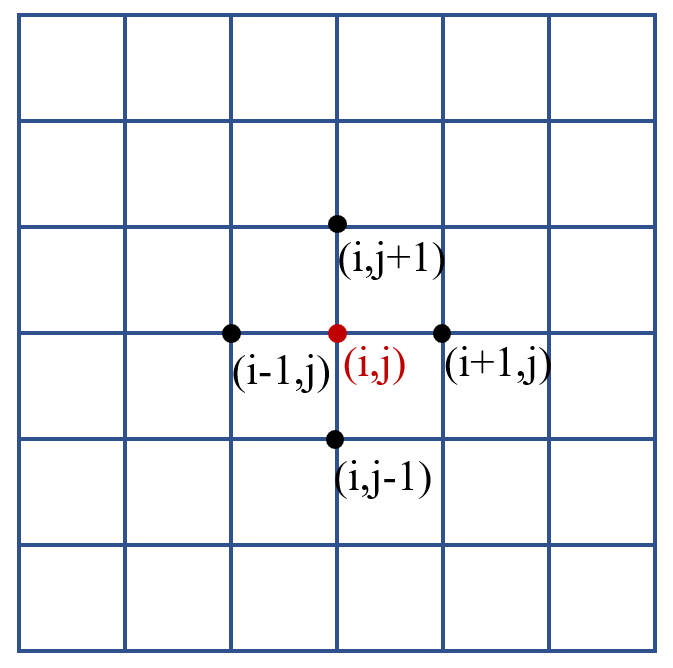

根据公式$\frac{\partial T}{\partial x}=\frac{T_{i+1}-T_i}{\Delta x}=\frac{T_{i}-T_{i-1}}{\Delta x}$可以推导出$\frac{\partial^2 T}{\partial x^2}=\frac{\partial}{\partial x}(\frac{\partial T}{\partial x})=\frac{T_{i+1}-2T_i+T_{i-1}}{\Delta x^2}$

最后可得：
$$ \frac{T_{i,j}^{(m+1)} - u_{i,j}^{(m)}}{\Delta t}=\alpha \left( \frac{T_{i+1,j}^{(m)} -2T_{i,j}^{(m)} + T_{i-1,j}^{(m)}}{\Delta x^2} + \frac{T_{i,j+1}^{(m)} -2T_{i,j}^{(m)} + T_{i,j-1}^{(m)}}{\Delta y^2}\right) $$

令$\Delta x=\Delta y$，移项可得：
$$T_{i,j}^{(m+1)} = u_{i,j}^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( T_{i+1,j}^{(m)} + T_{i-1,j}^{(m)} +  T_{i,j+1}^{(m)} + T_{i,j-1}^{(m)}  -4T_{i,j}^{(m)} \right)$$

# 3. 编程

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. 设定材料参数

In [2]:
k=76.2    # 热导率 W/(m*K)
rho=7870  # 密度 kg/(m**3)
c=440     # 比热容 J/(kg*K)
alpha=k/rho/c   # 热扩散系数 m**2/s
alpha

2.200531361903662e-05

## 2. 设定迭代参数

In [3]:
n=100
x,y=np.linspace(0,1,n),np.linspace(0,1,n)

X,Y=np.meshgrid(x,y)
Z=((X-0.5)**2+(Y-0.5)**2<=0.04)

T_am=25
T_Fe=600
T=np.ones((n,n))*T_am  # 环境温度
T[Z]=T_Fe             # 铁饼温度

t=3600         # 也就是 1h
dt=1
times=int(t/dt)        # 循环次数
storage=360       # 要存储的时刻次数
f=times/storage   # 存储判断条件

dx=x[1]-x[0]
s=(alpha*dt)/(dx**2)
s,times,f

(0.21567407878017789, 3600, 10.0)

为了保证可解，对于二维情况，要保证$s<\frac{1}{4}$

## 2.2设定存储变量

In [4]:

TT=np.zeros((storage+1,n,n))

TT[0]=T

## 3. 检查参数

## 3.1 空间

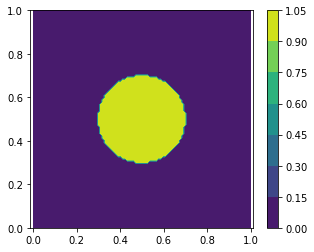

In [5]:
plt.figure(figsize=(5,4))
plt.contourf(X,Y,Z)
plt.colorbar()
plt.axis('equal')
plt.show()

## 3.2 初始温度分布

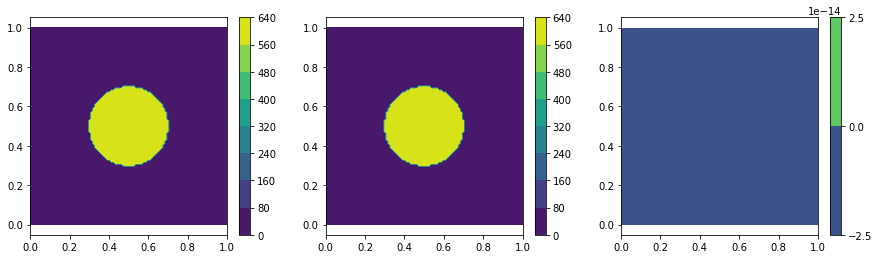

In [6]:
fig,axes=plt.subplots(1,3,figsize=(15,4))
ax0=axes[0]
a0=ax0.contourf(X,Y,T)
ax0.axis('equal')

ax1=axes[1]
a1=ax1.contourf(X,Y,TT[0])
ax1.axis('equal')

ax2=axes[2]
a2=ax2.contourf(X,Y,TT[18]) # 随便挑的
ax2.axis('equal')
fig.colorbar(a0,ax=ax0)
fig.colorbar(a1,ax=ax1)
fig.colorbar(a2,ax=ax2)
plt.show()

## 4. 开始迭代 

In [7]:
# 因为for循环较多，且使用numpy数组，所以可以使用numba加速
# 使用time函数展示一下numba加速的情况
import time

In [8]:
# 不使用加速情况
def solve(HT,Z):
    cT=HT[0].copy()  # 当前时刻温度 current T
    cf=0
    for tt in range(1,times+1):
        # 下一个时刻温度 next T
        nT=cT.copy()    # 这里copy的主要是环境温度，材料温度会进行迭代
        for i in range(1,n-1):     # 因为当前节点要通过前后，左右的节点来获得
            for j in range(1,n-1): # 现在这种写法是因为x，y方向的设置是一样的
                if Z[i,j]:         # 因为环境温度不变，只考虑材料即可
                    nT[i,j]=cT[i,j]+s*(cT[i+1,j]+cT[i-1,j]+cT[i,j+1]+cT[i,j-1]-4*cT[i,j])
        
        cT=nT.copy()   # 更新 
        if tt%f==0:
            cf+=1
            HT[cf]=cT.copy()
    
    return HT

In [ ]:
# 计算所用时间
start=time.time()
res=solve(TT,Z)
t1=time.time()-start

In [ ]:
# 展示结果
my_cmap = plt.get_cmap('inferno_r')
t_check=40 # 计算时，每隔10秒保存一次，所以检查的实际世界是 t_check*10
pc=plt.contourf(X,Y,TT[t_check],100,cmap=my_cmap)
cb=plt.colorbar(pc)
cb.set_label('Temp [℃]',fontsize=15)
plt.title('{:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT[t_check]),np.min(TT[t_check]))

In [ ]:
import numba
from numba import jit

In [ ]:
# 第一个f8[:,:,:]---- 函数返回值的数据类型，float，3维数组
# 第二个f8[:,:,:]---  函数第一个形参的数据类型，在括号内
# 第三个bl[:,:]---    函数第二个形参的数据类型，Boolean，2维数组
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve2(HT,Z):
    cT=HT[0].copy()  # 当前时刻温度 current T
    cf=0
    for tt in range(1,times+1):
        # 下一个时刻温度 next T
        nT=cT.copy()    # 这里copy的主要是环境温度，材料温度会进行迭代
        for i in range(1,n-1):     # 因为当前节点要通过前后，左右的节点来获得
            for j in range(1,n-1): # 现在这种写法是因为x，y方向的设置是一样的
                if Z[i,j]:         # 因为环境温度不变，只考虑材料即可
                    nT[i,j]=cT[i,j]+s*(cT[i+1,j]+cT[i-1,j]+cT[i,j+1]+cT[i,j-1]-4*cT[i,j])
        
        cT=nT.copy()   # 更新 
        if tt%f==0:
            cf+=1
            HT[cf]=cT
    
    return HT    

In [ ]:
# 加速后 计算所用时间
start=time.time()
TT=solve2(TT,Z)
t2=time.time()-start

In [ ]:
# 加速倍数
t1/t2

In [ ]:
my_cmap = plt.get_cmap('inferno_r')
t_check=240
pc=plt.contourf(X,Y,TT[t_check],100,cmap=my_cmap) # colorbar固定时，要把t_check置为0
cb=plt.colorbar(pc,format='%.1f')
cb.set_label('Temp [℃]', fontsize=15)
# plt.contourf(X,Y,TT[t_check],100,cmap=my_cmap,vmin=T_am,vmax=T_Fe) # colorbar固定时使用
plt.title('After {:.2f} min'.format(t_check*10/60),fontsize=20)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.show()
(np.max(TT[t_check]),np.min(TT[t_check]))

# 4. 数据展示——动画

In [ ]:
from matplotlib import animation

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
a = ax.contourf(X,Y,TT[40], 100, cmap=my_cmap,
                    vmin=T_am, vmax = T_Fe)
cbar = fig.colorbar(a)
cbar.set_label('Temp [$^\circ C$]', fontsize=15)
ax.set_title('Time = {:.2f} min'.format(40*f/60), fontsize=20)
ax.set_xlabel('$x$ [$m$]',fontsize=20)
ax.set_ylabel('$y$ [$m$]',fontsize=20)

In [ ]:
# 这个运行时间较长，现有参数下约十几秒
# 可以先把frames设定的小一些，如果效果满意再按实际设置
my_cmap = plt.get_cmap('inferno_r')
def init():
    a = ax.contourf(X,Y,TT[0], 100, cmap=my_cmap,
                    vmin=T_am, vmax = T_Fe)
    cbar = fig.colorbar(a)
    cbar.set_label('Temp [$^\circ C$]',fontsize=16)

def animate(i):
    ax.clear()
    ax.contourf(X,Y,TT[i], 100, cmap=my_cmap,
                vmin=T_am, vmax = T_Fe)
    ax.set_title('Time = {:.2f} min'.format(f*i/60), fontsize=20)
    ax.tick_params(axis='both',labelsize=16)
    ax.set_xlabel('$x$ [$m$]',fontsize=20)
    ax.set_ylabel('$y$ [$m$]',fontsize=20)
    return fig,

fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(1,storage+1), interval=100)
ani.save('cool.gif',writer='pillow',fps=30)